In [1]:
# Librerías que usamos
import numpy as np 
import pandas as pd 
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt 
from scipy.optimize import differential_evolution
from scipy.optimize import NonlinearConstraint, LinearConstraint, Bounds
from statsmodels.tsa.seasonal import seasonal_decompose

### Modelo a ajustar aquí 

Solo patada en los medios:

$$ \dot m = - p m + \alpha b_{\tau} $$

$$ \dot b = -q b + r m + k b b_{\tau}$$

donde $b_{\tau} = b(t - \tau)$ que puede ser reemplazada por un conjunto finito de ecuaciones diferenciales ordinarias que simulen una distribución de delays.


In [2]:
def integrate_model(args, tmax, x0):
    
    p, alpha, q, r, k, tau = args
    tt = np.arange(0, tmax, 0.01)
         
    def model(x, t, p, alpha, q, r, k, tau):
         
            n = len(x)
            fs = np.zeros(n)
            
            fs[0] = - p * x[0] + alpha * x[-1]
            fs[1] = - q * x[1] + r * x[0] + k * x[1] * x[-1]
            for i in range(2, n):
                fs[i] = ((n-2)/tau) * (x[i-1] - x[i])
    
            return fs
        
    # Integración numérica del modelo 
    yint = odeint(model, x0, tt, args=(p, alpha, q, r, k, tau), full_output=0)

    return tt, yint        

### Initial guess

In [18]:
# Fileid of the series to analyze
index = 40
filename = f'c:/Git_Proyects/Tesis/Faiss_vect/Tw_mas_RT_October/RT_Tw_cluster_{index}.csv'
df = pd.read_csv(filename)
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%a %b %d %H:%M:%S +0000 %Y')

categoria = 'RT'
df_categoria_true = df[df[categoria] == True]
df_categoria_false = df[df[categoria] == False]
df_categoria = [df_categoria_true, df_categoria_false]
max_date= []
trendss = []
for i, df1 in enumerate(df_categoria):
    df_index = df1.set_index('Fecha')
    df_count_hora = df_index.resample('1H').count()
    df_categoria = [df_categoria_true, df_categoria_false]
    result = seasonal_decompose(df_count_hora['Tweets'], model='additive')
    trend = result.trend.fillna(0)

    fecha_max_apariciones = trend.idxmax()
    max_date.append(fecha_max_apariciones)
    fecha_inicio = max_date[0] - pd.Timedelta(hours=1)
    fecha_fin = max_date[0] + pd.Timedelta(days=5)
    trednd_max = trend.loc[str(fecha_inicio):str(fecha_fin)]

    trendss.append(trednd_max)

In [19]:
#t0 = pd.DataFrame(trendss[0].index, trendss[0].values, columns={'Tiemo', 'Tweets'})
#t0.rename(columns={'Tweets'})
#pd.DataFrame.from_dict(trendss[0], orient='index')
d1 = {'time': trendss[0].index, 'blog':trendss[0].values/max(trendss[0].values)}
d2 = {'time': trendss[1].index, 'media':trendss[1].values/max(trendss[1].values)}

dfRT = pd.DataFrame(d1)
dfT = pd.DataFrame(d2)

data = dfRT.merge(dfT, on='time')
data

,time,blog,media
0,2019-10-21 23:00:00,0.990921,1.000000
1,2019-10-22 00:00:00,1.000000,1.000000
2,2019-10-22 01:00:00,0.993571,0.916279
3,2019-10-22 02:00:00,0.877792,0.716279
4,2019-10-22 03:00:00,0.721254,0.539535
...,...,...,...
117,2019-10-26 20:00:00,0.000928,0.027907
118,2019-10-26 21:00:00,0.000928,0.027907
119,2019-10-26 22:00:00,0.000928,0.027907
120,2019-10-26 23:00:00,0.000928,0.027907


In [20]:
#filename = f'c:/Git_Proyects/Tesis/Faiss_vect/Tw_mas_RT_October/RT_Tw_cluster_{index}.csv'

#data = pd.read_csv(filename, parse_dates=[0])
data.set_index('time', inplace=True)
data.media = data.media.div(data.media.max())
data.blog = data.blog.div(data.blog.max())

# Cambiar acá si queremos ajustar solo una parte de los datos
init_index = data.media.argmax()
data = data[init_index:init_index + 168]

In [21]:
data

,blog,media
time,,
2019-10-21 23:00:00,0.990921,1.000000
2019-10-22 00:00:00,1.000000,1.000000
2019-10-22 01:00:00,0.993571,0.916279
2019-10-22 02:00:00,0.877792,0.716279
2019-10-22 03:00:00,0.721254,0.539535
...,...,...
2019-10-26 20:00:00,0.000928,0.027907
2019-10-26 21:00:00,0.000928,0.027907
2019-10-26 22:00:00,0.000928,0.027907


In [33]:
# Start parameters: ['p', 'alpha', 'q', 'r', 'k', 'tau']
start_params = [0.1, 0.1, 0.3, 0.3, 0.00, 90]

# Figures
ngammas = 63
coeffs = start_params
x0 = [1.00, 1.00] + [0.00] * ngammas

tt, yy = integrate_model(coeffs, data.shape[0], x0)

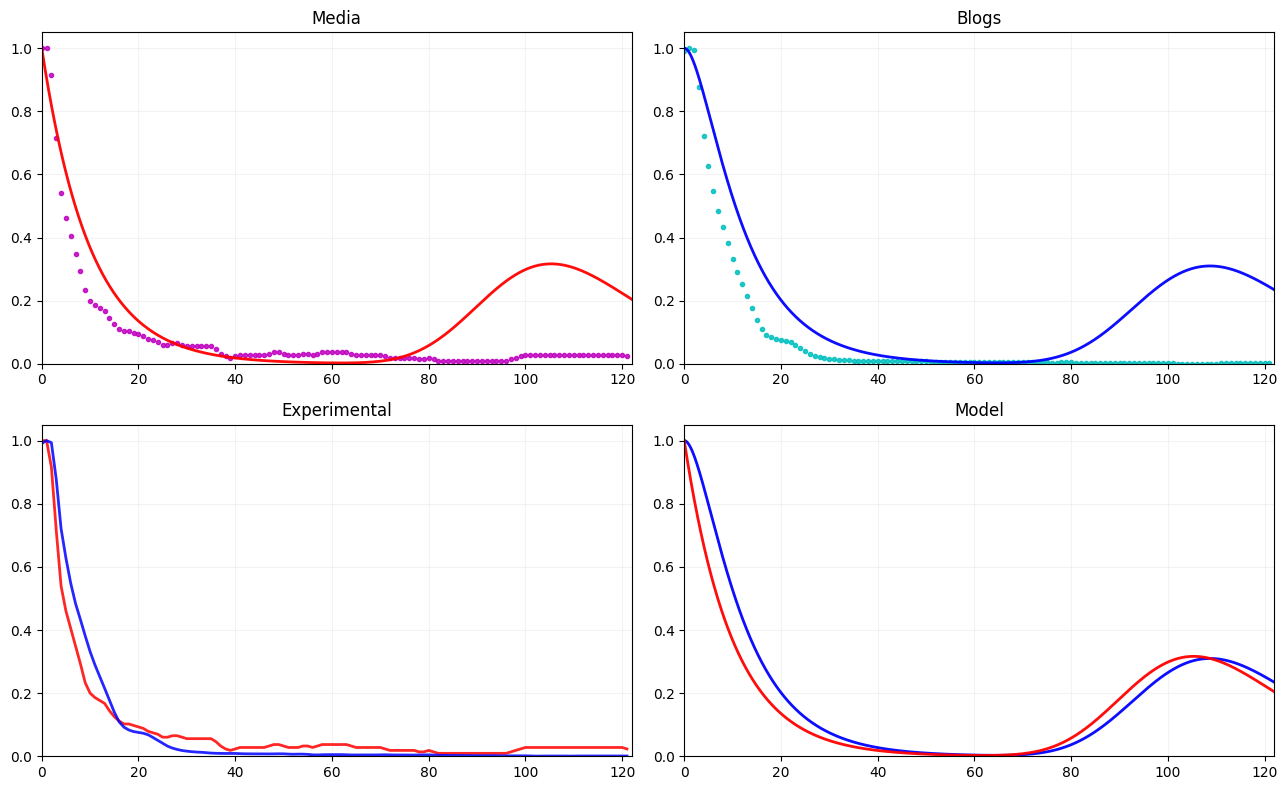

In [34]:
fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize = (13,8), dpi = 100)
ax.plot(data.media.to_numpy(), '.', color = 'm', linewidth = 2, label = 'media', alpha = 0.85)
ax.plot(tt, yy[:,0], color = 'red',  linestyle = '-', linewidth = 2, alpha = 0.95)
ax.set_ylim([0.00, 1.05])
ax.set_xlim([0, data.shape[0]])
ax.grid(True, alpha = 0.15)
ax.set_title('Media')

ax2.plot(data.blog.to_numpy(), '.', color = 'c', linewidth = 2, label = 'blog', alpha = 0.85)
ax2.plot(tt, yy[:,1], color = 'blue', linewidth = 2, linestyle = '-', alpha = 0.95)
ax2.set_ylim([0.00, 1.05])
ax2.set_xlim([0, data.shape[0]])
ax2.grid(True, alpha = 0.15)
ax2.set_title('Blogs')

ax3.plot(data.media.to_numpy(), '-', color = 'r', linewidth = 2, label = 'media', alpha = 0.85)
ax3.plot(data.blog.to_numpy(), '-', color = 'b', linewidth = 2, label = 'blog', alpha = 0.85)

ax3.set_ylim([0.00, 1.05])
ax3.set_xlim([0, data.shape[0]])
ax3.grid(True, alpha = 0.15)
ax3.set_title('Experimental')

ax4.plot(tt, yy[:,1], color = 'blue', linewidth = 2, linestyle = '-', alpha = 0.95)
ax4.plot(tt, yy[:,0], color = 'red',  linestyle = '-', linewidth = 2, alpha = 0.95)

ax4.set_ylim([0.00, 1.05])
ax4.set_xlim([0, data.shape[0]])
ax4.grid(True, alpha = 0.15)
ax4.set_title('Model')

fig.tight_layout()


plt.show()

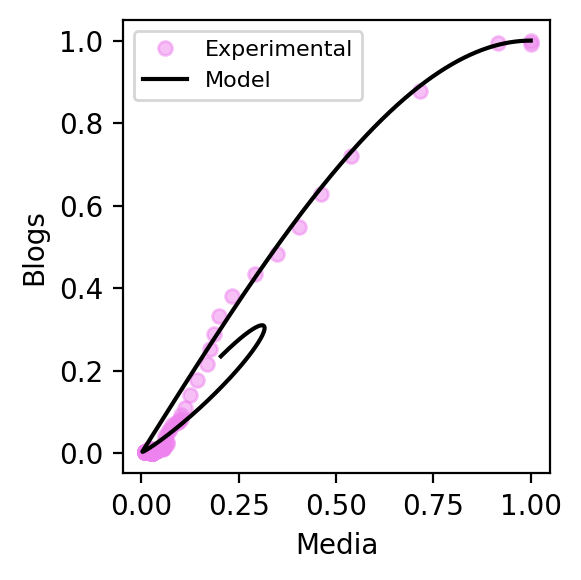

In [35]:
# Phase diagram

plt.figure(figsize = (3,3), dpi = 200)
plt.plot(data.media.to_numpy(), data.blog.to_numpy(), '.', markersize = 10, alpha = 0.50, color = 'violet', label = 'Experimental')
plt.plot(yy[:,0], yy[:,1], color = 'k', label = 'Model')
plt.xlabel('Media')
plt.ylabel('Blogs')
plt.legend(loc = 'best', fontsize = 8)
plt.tight_layout()
plt.show()

### Parameter fitting

In [36]:
def function2minimize(all_coeffs, data, ngammas):
    
    coeffs = all_coeffs[:(len(all_coeffs) - 2)]
    
    x0 = all_coeffs[-2:]
    x0 = list(x0) + [0.00]*ngammas
    
    tt, yy = integrate_model(coeffs, data.shape[0], x0)
    
    media_integrated = yy[tt % 1 == 0][:data.shape[0], 0]
    blog_integrated = yy[tt % 1 == 0][:data.shape[0], 1]
    
    error = (((media_integrated - data.media.to_numpy())**2) + ((blog_integrated - data.blog.to_numpy())**2))**0.5
    
    return np.mean(error)

In [37]:
function2minimize(coeffs + [1.00, 1.00], data, ngammas)

0.15371429018564237

In [38]:
lims = {'p': [0.001, 1], 
            'alpha': [0.001, 1],
            'q': [0.001, 1], 
            'r': [0.001, 1], 
            'k': [-10.00, 10.00], 
            'tau': [12, data.shape[0]-24],
            'm0': [0.75, 1.25],
            'b0': [0.75*data.blog.iloc[0], 1.25*data.blog.iloc[0]]}

lower_bounds = [l[0] for l in lims.values()]
upper_bounds = [l[1] for l in lims.values()]

bounds = Bounds(lower_bounds, upper_bounds)

In [39]:
popsize = 8 # cantidad de chobis, esto son 64 parametros en simultaneo por 8 bichos por 8 prametros
ngammas = 30
sol = differential_evolution(function2minimize, bounds=bounds, args=(data, ngammas), 
                                 popsize=popsize, recombination = 0.30, mutation = (0.1, 1.9),
                                 updating='deferred', workers = 1, tol = 0.001,
                                 polish= False, disp = True, maxiter = 200, x0 = start_params + [1.00, data.blog[0]])

differential_evolution step 1: f(x)= 0.055346
differential_evolution step 2: f(x)= 0.0385145
differential_evolution step 3: f(x)= 0.0385145
differential_evolution step 4: f(x)= 0.0385145
differential_evolution step 5: f(x)= 0.0385145
differential_evolution step 6: f(x)= 0.0385145
differential_evolution step 7: f(x)= 0.0385145
differential_evolution step 8: f(x)= 0.0385145
differential_evolution step 9: f(x)= 0.0385145
differential_evolution step 10: f(x)= 0.0379475
differential_evolution step 11: f(x)= 0.036511
differential_evolution step 12: f(x)= 0.036511
differential_evolution step 13: f(x)= 0.036511
differential_evolution step 14: f(x)= 0.036511
differential_evolution step 15: f(x)= 0.036511
differential_evolution step 16: f(x)= 0.036122
differential_evolution step 17: f(x)= 0.0354492
differential_evolution step 18: f(x)= 0.0347021
differential_evolution step 19: f(x)= 0.0347021
differential_evolution step 20: f(x)= 0.0308181
differential_evolution step 21: f(x)= 0.0308181
differen

#### Result

In [40]:
sol

 message: Maximum number of iterations has been exceeded.
 success: False
     fun: 0.021007712584307874
       x: [ 1.422e-01  1.875e-02  6.098e-01  6.257e-01 -9.980e+00
            4.615e+01  1.001e+00  9.918e-01]
     nit: 200
    nfev: 12864

In [41]:
# Integration of the model with final parameters
coeffs = sol.x[:len(sol.x)-2]
x0 = list(sol.x[-2:]) + [0.00] * ngammas

tt, yy = integrate_model(coeffs, data.shape[0], x0)

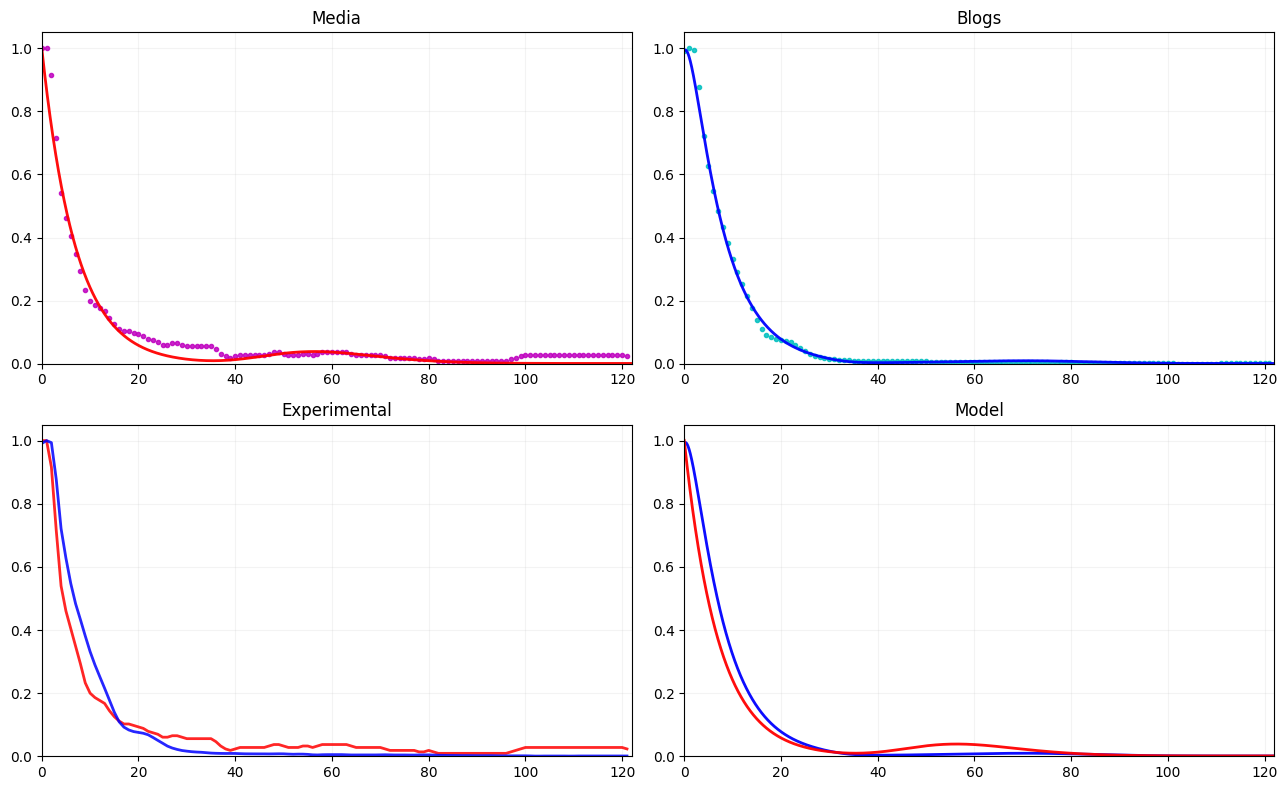

In [42]:
# Figures

fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize = (13,8), dpi = 100)
ax.plot(data.media.to_numpy(), '.', color = 'm', linewidth = 2, label = 'media', alpha = 0.85)
ax.plot(tt, yy[:,0], color = 'red',  linestyle = '-', linewidth = 2, alpha = 0.95)
ax.set_ylim([0.00, 1.05])
ax.set_xlim([0, data.shape[0]])
ax.grid(True, alpha = 0.15)
ax.set_title('Media')

ax2.plot(data.blog.to_numpy(), '.', color = 'c', linewidth = 2, label = 'blog', alpha = 0.85)
ax2.plot(tt, yy[:,1], color = 'blue', linewidth = 2, linestyle = '-', alpha = 0.95)
ax2.set_ylim([0.00, 1.05])
ax2.set_xlim([0, data.shape[0]])
ax2.grid(True, alpha = 0.15)
ax2.set_title('Blogs')

ax3.plot(data.media.to_numpy(), '-', color = 'r', linewidth = 2, label = 'media', alpha = 0.85)
ax3.plot(data.blog.to_numpy(), '-', color = 'b', linewidth = 2, label = 'blog', alpha = 0.85)

ax3.set_ylim([0.00, 1.05])
ax3.set_xlim([0, data.shape[0]])
ax3.grid(True, alpha = 0.15)
ax3.set_title('Experimental')

ax4.plot(tt, yy[:,1], color = 'blue', linewidth = 2, linestyle = '-', alpha = 0.95)
ax4.plot(tt, yy[:,0], color = 'red',  linestyle = '-', linewidth = 2, alpha = 0.95)

ax4.set_ylim([0.00, 1.05])
ax4.set_xlim([0, data.shape[0]])
ax4.grid(True, alpha = 0.15)
ax4.set_title('Model')

fig.tight_layout()

plt.show()

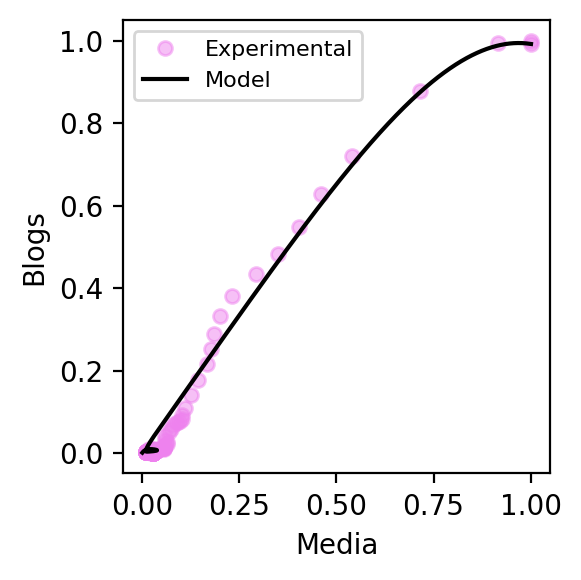

In [43]:
# Phase diagram

plt.figure(figsize = (3,3), dpi = 200)
plt.plot(data.media.to_numpy(), data.blog.to_numpy(), '.', markersize = 10, alpha = 0.50, color = 'violet', label = 'Experimental')
plt.plot(yy[:,0], yy[:,1], color = 'k', label = 'Model')
plt.xlabel('Media')
plt.ylabel('Blogs')
plt.legend(loc = 'best', fontsize = 8)
plt.tight_layout()
plt.show()